# Visualisation des données de la campagne "visite page produit" de l'annonceur 2

## Visualisation des données brutes

In [1]:
# fichiers contenant les fonctions utiles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels
from part1 import *
from part2 import *
from part3 import *

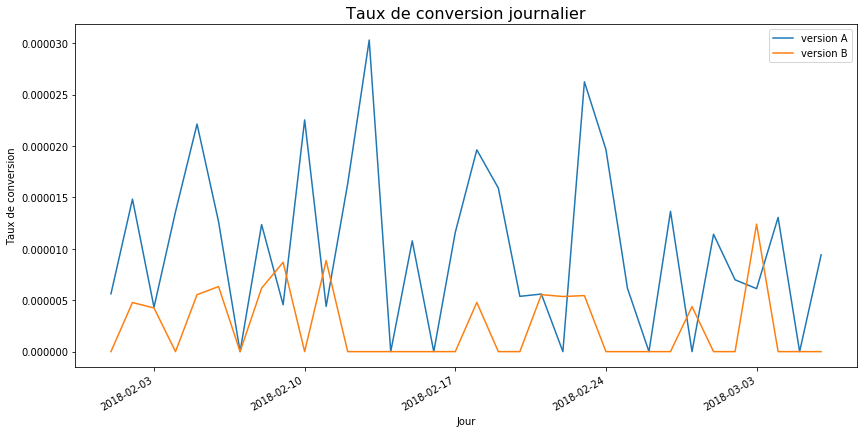

In [2]:
datasetA = pd.read_hdf('/Users/guillaumeshi/PycharmProjects/1000mercis/Data/annonceur2/annonceur2_daily.hdf', key='visite_page_produitA')
datasetB = pd.read_hdf('/Users/guillaumeshi/PycharmProjects/1000mercis/Data/annonceur2/annonceur2_daily.hdf', key='visite_page_produitB')
plt.rcParams["figure.figsize"] = (14,7)
fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.plot_date(datasetA.index, datasetA['conv_rate'], marker='', linestyle='-')
plt.plot(datasetA.index, datasetB['conv_rate'])
plt.xlabel('Jour')
plt.ylabel('Taux de conversion')
plt.title('Taux de conversion journalier', fontsize=16)
plt.legend(['version A', 'version B'], loc='best')
plt.show()

On voit ainsi que la version B semble moins efficace que la version A, ce qui reste à démontrer via un test d'hypothèses.

## Différence relative des taux de conversion

On regarde si le niveau d'agrégation (jour ou semaine) permettrait d'établir une différence relative importante entre les taux de conversions issus des deux versions. On notera toutefois que cette différence relative ne peut être calculée pour certains jours puisque le taux de conversion de la version A est parfois nul.

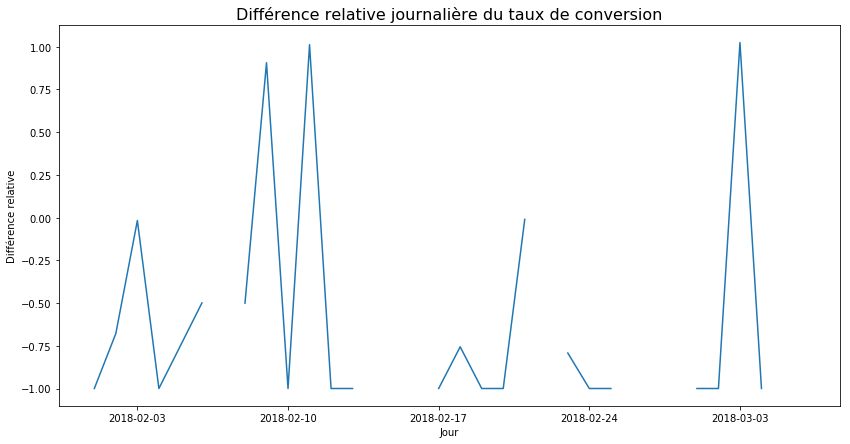

In [3]:
daily_relative_difference = (datasetB['conv_rate'] - datasetA['conv_rate']) / datasetA['conv_rate']

plt.rcParams["figure.figsize"] = (14,7)
plt.plot(datasetA.index, daily_relative_difference)
plt.xlabel('Jour')
plt.ylabel('Différence relative')
plt.title('Différence relative journalière du taux de conversion', fontsize=16)
plt.show()

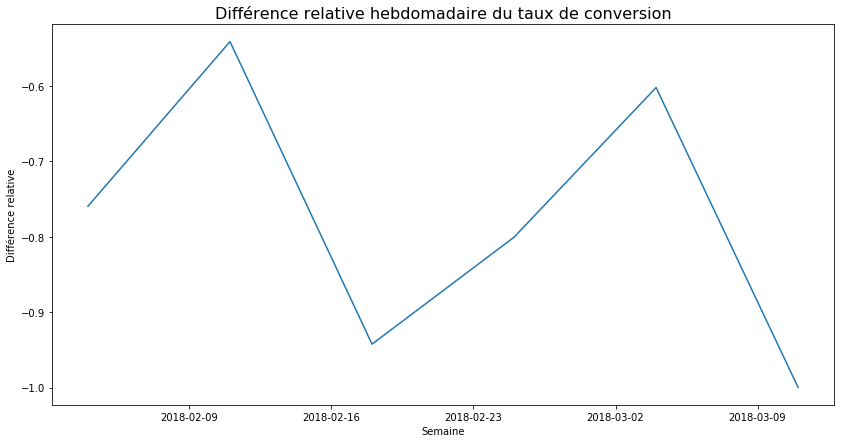

In [4]:
weekly_datasetA = datasetA.resample('W').sum()
weekly_datasetA['conv_rate'] = weekly_datasetA['n_convs'] / weekly_datasetA['total_impressions']

weekly_datasetB = datasetB.resample('W').sum()
weekly_datasetB['conv_rate'] = weekly_datasetB['n_convs'] / weekly_datasetB['total_impressions']

weekly_relative_difference = (weekly_datasetB - weekly_datasetA) / weekly_datasetA

plt.rcParams["figure.figsize"] = (14,7)
plt.plot(weekly_relative_difference.index, weekly_relative_difference['conv_rate'])
plt.xlabel('Semaine')
plt.ylabel('Différence relative')
plt.title('Différence relative hebdomadaire du taux de conversion', fontsize=16)
plt.show()

Il semblerait ainsi que sur la plage temporelle étudiée, la différence relative était négative décroisse jusqu'à atteindre la valeur -1 : d'un point de vue hebdomadaire, le taux de conversion sous la version B était inférieur à celui sous la version A, et vers la fin de la campagne, la version B n'engendrait presque plus de conversion.

# Analyse des données de la campagne "visite page produit" de l'annonceur 2

## Stationnarité des données

On s'intéresse dans un premier temps à la stationnarité des données : le taux de conversion dépend-t-il du jour de la visite ? Y a-t-il des jours où le taux de conversion semble influencer la conversion des utilisateurs ?

In [5]:
adf_test(datasetA['conv_rate'])

,Results of Augmented Dickey-Fuller test:
test statistic,-6.559938e+00
p-value,8.430668e-09
# of lags,0.000000e+00
# of observations,3.300000e+01
Critical Value (1%),-3.646135e+00
Critical Value (5%),-2.954127e+00
Critical Value (10%),-2.615968e+00


In [6]:
adf_test(datasetB['conv_rate'])

,Results of Augmented Dickey-Fuller test:
test statistic,-6.159365e+00
p-value,7.236679e-08
# of lags,0.000000e+00
# of observations,3.300000e+01
Critical Value (1%),-3.646135e+00
Critical Value (5%),-2.954127e+00
Critical Value (10%),-2.615968e+00


Un test de Dickey-Fuller sur la série temporelle des taux de conversions journaliers pour la version A indique que celle-ci est stationnaire (p-value inférieure à 1%). De même, la série temporelle pour la version B indique que celle-ci est stationnaire.

In [7]:
adf_test(list(np.diff(datasetA['conv_rate'])))

,Results of Augmented Dickey-Fuller test:
test statistic,-6.306489e+00
p-value,3.313809e-08
# of lags,3.000000e+00
# of observations,2.900000e+01
Critical Value (1%),-3.679060e+00
Critical Value (5%),-2.967882e+00
Critical Value (10%),-2.623158e+00


In [8]:
adf_test(list(np.diff(datasetB['conv_rate'])))

,Results of Augmented Dickey-Fuller test:
test statistic,-8.350228e+00
p-value,3.008578e-13
# of lags,1.000000e+00
# of observations,3.100000e+01
Critical Value (1%),-3.661429e+00
Critical Value (5%),-2.960525e+00
Critical Value (10%),-2.619319e+00


On a toujours stationnarité des séries temporelles après différenciation.

## Saisonnalité des données

On essaie ensuite de voir si de la série temporelle on peut dégager certaines tendances : tendance globale, composante saisonnière et résidu, le but étant de voir si les taux de conversion peuvent être affectés par certains cycles temporels, et, le cas échéant, dans quelle mesure. Puisque nous travaillons avec des taux de conversion dont les valeurs peuvent être nulles, on se focalisera essentiellement sur des modèles additifs.

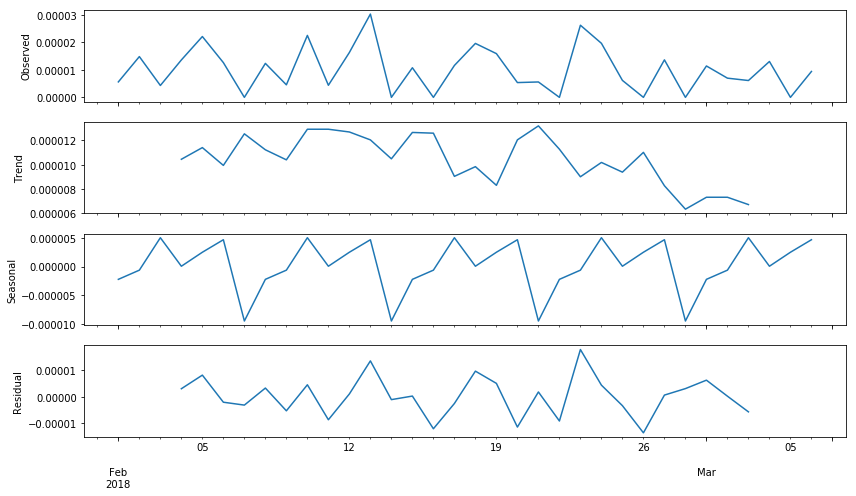

In [8]:
conversion_rate = datasetA['conv_rate']
conversion_rate.index = pd.to_datetime(conversion_rate.index)
decomposition = statsmodels.tsa.seasonal.seasonal_decompose(conversion_rate, model="additive")
plt.rcParams["figure.figsize"] = (12,7)
decomposition.plot()
plt.show()

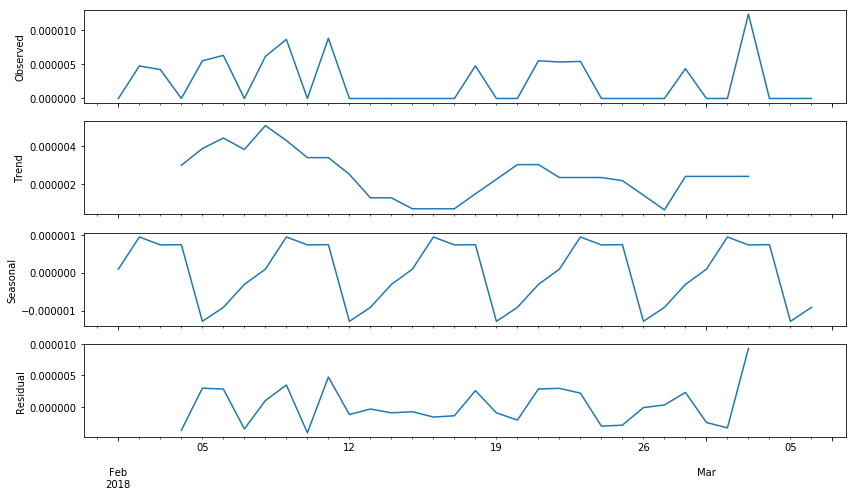

In [9]:
conversion_rate = datasetB['conv_rate']
conversion_rate.index = pd.to_datetime(conversion_rate.index)
decomposition = statsmodels.tsa.seasonal.seasonal_decompose(conversion_rate, model="additive")
plt.rcParams["figure.figsize"] = (12,7)
decomposition.plot()
plt.show()

# Z-test : conclusion quant à l'efficacité du test A/B mené

## Z-test global

Enfin, on conduit un Z-test destiné à mesurer l'efficacité statistique du test A/B mené. Mathématiquement, cela se traduit par la comparaison de l'hypothèse nulle H0 : "le taux de conversion sous version A est le même que celui sous version B" avec l'hypothèse H1 : "le taux de conversion sous version A est différent que celui sous version B". En d'autres termes, l'hypothèse H1 traduit le fait que la version B a bel et bien une influence sur le taux de conversion.

In [10]:
from scipy.stats import norm
pA = sum(datasetA['n_convs']) / sum(datasetA['total_impressions'])
pB = sum(datasetB['n_convs']) / sum(datasetB['total_impressions'])

nA = sum(datasetA['total_impressions'])
nB = sum(datasetB['total_impressions'])

Z_value = (pA - pB) / np.sqrt(pA * (1 - pA) / nA + pB * (1 - pB) / nB)
p_val = 1 - norm.cdf(abs(Z_value)) + norm.cdf(-abs(Z_value))

print(p_val)

7.947137968280094e-08


On obtient une p-valeur inférieure aux seuils usuels de 10%, 5% ou 1%. On rejette donc l'hypothèse H0 et on en déduit alors que **la version B semble avoir plus d'influence sur le taux de conversion que la version A. En effet, comme vu précédemment, la version B semble moins efficace que la version A**.

## Z-test cumulé (pas journalier)

On s'intéresse maintenant aux **données cumulées** : en regardant l'ensemble des informations dont on dispose du jour 1 de la campagne publicitaire au jour n, peut-on voir une certaine tendance quant au test d'hypothèses ?

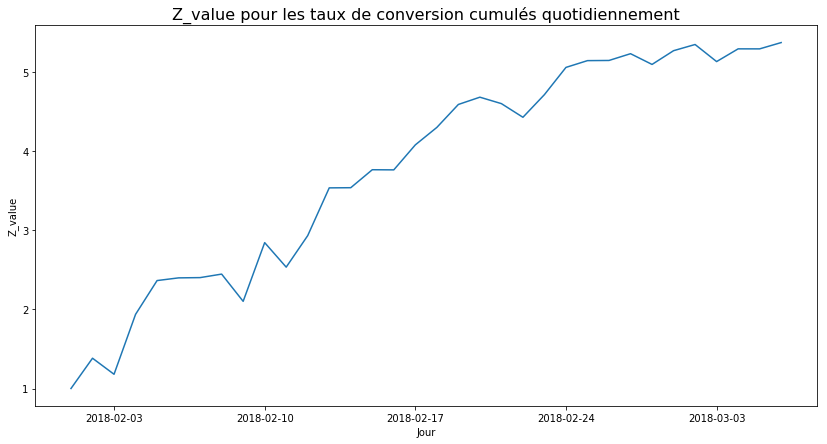

In [11]:
daily_cumsum_datasetA = datasetA[['total_impressions', 'n_convs']].cumsum()
daily_cumsum_datasetB = datasetB[['total_impressions', 'n_convs']].cumsum()
daily_cumsum_datasetA['conv_rate'] = daily_cumsum_datasetA['n_convs'] / daily_cumsum_datasetA['total_impressions']
daily_cumsum_datasetB['conv_rate'] = daily_cumsum_datasetB['n_convs'] / daily_cumsum_datasetB['total_impressions']

Z_value = []
p_value = []

for date in daily_cumsum_datasetA.index:
    pA = daily_cumsum_datasetA.loc[date]['conv_rate']
    nA = daily_cumsum_datasetA.loc[date]['total_impressions']
    pB = daily_cumsum_datasetB.loc[date]['conv_rate']
    nB = daily_cumsum_datasetB.loc[date]['total_impressions']
    Z_value.append((pA-pB)/np.sqrt(pA*(1-pA)/nA + pB*(1-pB)/nB))
    p_value.append(1 - norm.cdf(abs(Z_value[-1])) + norm.cdf(-abs(Z_value[-1])))

        
plt.rcParams["figure.figsize"] = (14,7)
plt.plot(daily_cumsum_datasetA.index, Z_value)
plt.xlabel('Jour')
plt.ylabel('Z_value')
plt.title('Z_value pour les taux de conversion cumulés quotidiennement', fontsize=16)
plt.show()

La Z-value est toujours positive. Cette valeur était du signe de la différence entre le taux de conversion sous version A et celui sous version B, cela nous indique qu'a priori, la version A était meilleure que la version B. Il reste à voir si cela peut être confirmé ou infirmé statistiquement. On s'intéresse ainsi à l'évoluation de la p-valeur.

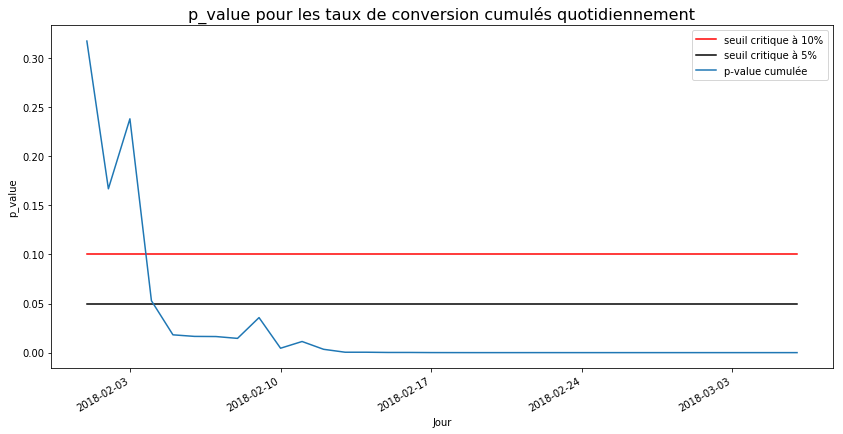

In [15]:
plt.rcParams["figure.figsize"] = (14,7)

fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.plot_date(datasetA.index, [0.1]*len(datasetA.index), marker='', linestyle='-', c='red')
ax.plot_date(datasetA.index, [0.05]*len(datasetA.index), marker='', linestyle='-', c='black')
plt.plot(daily_cumsum_datasetA.index, p_value)
plt.xlabel('Jour')
plt.ylabel('p_value')
plt.title('p_value pour les taux de conversion cumulés quotidiennement', fontsize=16)
plt.legend(['seuil critique à 10%', 'seuil critique à 5%', 'p-value cumulée'], loc='best')
plt.show()

On voit ainsi que la p-value cumulée se situe au-delà du seuil critique à 5% jusqu'au 4 février 2018 environ, soit approximativement le début de la campagne. En d'autres termes, l'hypothèse nulle "la version B n'a pas plus d'influence que la version A sur le taux de conversion" aurait été acceptée si la campagne avait pris fin avant le 4 février. Néanmoins, il se trouve que la p-value descend sous le seuil critique de 5% après cette date, et qu'elle reste très basse jusqu'à la fin de la campagne. Autrement dit, une vue globale de la campagne après le 4 février permet de rejeter l'hypothèse nulle et donc d'**accepter l'hypothèse selon laquelle la version B donne de moins bons résultats que la version A**.

Avec un seuil critique à 10%, on aurait tout de même rejeté l'hypothèse nulle dès le 4 février. En fait, on remarque d'ailleurs une chute brutale de la p-value cumulée à partir du 3 février. Au regard du graphique montrant l'évolution temporelle de la Z-value cumulée, cela signifie concrètement que **dès le 4 février, on avait suffisamment de significativité (que ce soit à 5% ou 10% voire 20%) pour en déduire que la version B était moins performante que la version A**, et que cette remarque persiste jusqu'à la fin de la campagne.

## Z-test cumulé (pas de 3 jours)

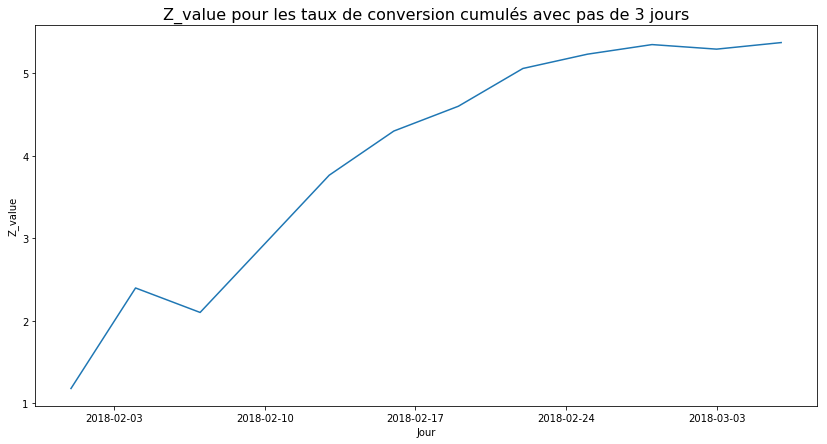

In [20]:
def cumulated_dataset_freq(dataset, frequency):  # dataset cumulé avec un pas de frequency jours
    cumulated_dataset = dataset.resample(frequency).sum().cumsum()
    cumulated_dataset['conv_rate'] = cumulated_dataset['n_convs'] / cumulated_dataset['total_impressions']
    return cumulated_dataset

frequency = '3D'

cumulated_datasetA = cumulated_dataset_freq(datasetA, frequency)
cumulated_datasetB = cumulated_dataset_freq(datasetB, frequency)

Z_value = []
p_value = []

for date in cumulated_datasetA.index:
    pA = cumulated_datasetA.loc[date]['conv_rate']
    nA = cumulated_datasetA.loc[date]['total_impressions']
    pB = cumulated_datasetB.loc[date]['conv_rate']
    nB = cumulated_datasetB.loc[date]['total_impressions']
    Z_value.append((pA-pB)/np.sqrt(pA*(1-pA)/nA + pB*(1-pB)/nB))
    p_value.append(1 - norm.cdf(abs(Z_value[-1])) + norm.cdf(-abs(Z_value[-1])))
    
plt.rcParams["figure.figsize"] = (14,7)
plt.plot(cumulated_datasetA.index, Z_value)
plt.xlabel('Jour')
plt.ylabel('Z_value')
plt.title(f'Z_value pour les taux de conversion cumulés avec pas de {frequency[0]} jours', fontsize=16)
plt.show()

L'évolution de la Z-value est ainsi similaire à celle trouvée avec un pas quotidien. En effet, en prenant une fenêtre temporelle plus large pour regarder le cumul des données, on obtient une courbe plus lissée car celle-ci agrège les données à un plus haut niveau. L'allure reste toutefois semblable à celle où la fenêtre est plus réduite (et donc plus précise). Intéressons maintenant l'évolution de la p-value : **une fenêtre temporelle de 3 jours pour le cumul des données change-t-il la significativité du test, et donc la conclusion finale ?**

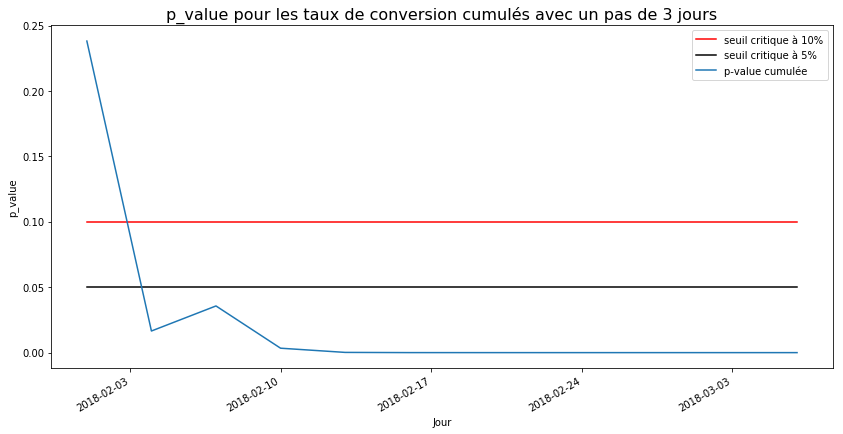

In [21]:
plt.rcParams["figure.figsize"] = (14,7)

fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.plot_date(cumulated_datasetA.index, [0.1]*len(cumulated_datasetA.index), marker='', linestyle='-', c='red')
ax.plot_date(cumulated_datasetA.index, [0.05]*len(cumulated_datasetA.index), marker='', linestyle='-', c='black')
plt.plot(cumulated_datasetA.index, p_value)
plt.xlabel('Jour')
plt.ylabel('p_value')
plt.title(f'p_value pour les taux de conversion cumulés avec un pas de {frequency[0]} jours', fontsize=16)
plt.legend(['seuil critique à 10%', 'seuil critique à 5%', 'p-value cumulée'], loc='best')
plt.show()

Une fois de plus, on voit que la p-value du Z-test cumulé chute brutalement au début de la campagne publicitaire : cela signifie que dès le début, une version se démarque de l'autre par un taux de conversion sensiblement plus élevé. **Une observation globale des données à partir du 4 février suggère que la version A engendre un meilleur taux de conversion que la version B, et que cette remarque peut être affirmée avec un niveau de significativité quelconque (5%, 10% etc)**. De plus, la p-value restant très en-dessous du seuil critique à 5% pour toute la durée du test, on peut aussi affirmer qu'**à n'importe quel moment postérieur au 4 février, la version A était meilleure que la version B en termes de taux de conversion**.